In [1]:
!pip install -q torch transformers langchain sentence-transformers tqdm openpyxl openai pandas datasets langchain-community ragatouille


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.7/86.7 kB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 32.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 24.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.5/171.5 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.5/27.5 MB 32.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 kB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 49.8 MB/s eta 0:00:00
   ━━━

In [2]:
from datasets import load_dataset
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.docstore.document import Document as LangchainDocument
import pandas as pd

# Load the Excel file as a dataset
file_path = 'structured_10k.csv'
df = pd.read_csv(file_path)

# Combine all columns into a single text for splitting
combined_text = " ".join(df[col].dropna().str.cat(sep=" ") for col in df.columns)

# Split documents into manageable chunks
text_splitter = RecursiveCharacterTextSplitter(chunk_size=2000, chunk_overlap=200)
docs_processed = text_splitter.create_documents([combined_text])


In [3]:
hf_token = ""

In [4]:
from huggingface_hub import InferenceClient
import pandas as pd

# Initialize the client for LLM
llm_client = InferenceClient(
    model="mistralai/Mixtral-8x7B-Instruct-v0.1",
    token=hf_token,
    timeout=120,
)
try:
    # Test connection by generating a chat response
    messages = [{"role": "user", "content": "This is a test prompt"}]
    response = llm_client.chat_completion(messages, max_tokens=10)
    print("Connection successful!")
    print("Generated Response:", response.choices[0].message.content)
except Exception as e:
    print(f"Connection failed: {e}")

Connection successful!
Generated Response:  I'm here to help! However, I


In [19]:
from huggingface_hub import InferenceClient
import pandas as pd

# Initialize the client for LLM
llm_client = InferenceClient(
    model="mistralai/Mixtral-8x7B-Instruct-v0.1",
    token=hf_token,
    timeout=120,
)

# Prompt template for QA generation
QA_generation_prompt = """
Your task is to write a factoid question and an answer given a context.
Your factoid question should be answerable with a specific, concise piece of factual information from the context.
Provide your answer as follows:

Output:::
Factoid question: (your factoid question)
Answer: (your answer to the factoid question)

Now here is the context.

Context: {context}\n
Output:::
"""

# Generate QA pairs
outputs = []
print("Starting QA pair generation...")

for idx, doc in enumerate(docs_processed[:10]):  # Generate only 10 QA pairs for testing
    print(f"\nProcessing document {idx + 1}/{len(docs_processed[:10])}...")
    try:
        messages = [{"role": "user", "content": QA_generation_prompt.format(context=doc.page_content)}]
        response = llm_client.chat_completion(messages, max_tokens=100)
        print("Response received. Parsing the generated output...")
        output_text = response.choices[0].message.content
        question = output_text.split("Factoid question: ")[-1].split("Answer: ")[0].strip()
        answer = output_text.split("Answer: ")[-1].strip()
        outputs.append({"context": doc.page_content, "question": question, "answer": answer})
        print(f"Generated Question: {question}")
        print(f"Generated Answer: {answer}")
    except Exception as e:
        print(f"An error occurred while processing document {idx + 1}: {e}")
        continue

# Save the synthetic dataset
qa_dataset = pd.DataFrame(outputs)
qa_dataset.to_csv("synthetic_qa.csv", index=False)
print(f"\nQA pair generation completed. {len(outputs)} QA pairs generated and saved to 'synthetic_qa.csv'.")


Starting QA pair generation...

Processing document 1/10...
Response received. Parsing the generated output...
Generated Question: What is the name of Apple's first spatial computer?
Generated Answer: Apple Vision Pro

Processing document 2/10...
Response received. Parsing the generated output...
Generated Question: In which geographical regions does Apple manage its business and offer its products and services?
Generated Answer: Apple manages its business in the Americas (including North and South America), Europe (including European countries, India, the Middle East and Africa), Greater China (including China mainland, Hong Kong and Taiwan), Japan, and the Rest of Asia Pacific (including Australia and other Asian countries).

Processing document 3/10...
Response received. Parsing the generated output...
Generated Question: What percentage of Apple Inc.'s total net sales in 2024 were made through indirect distribution channels?
Generated Answer: 62%

Explanation:
The context mentions 

In [21]:
import re

critique_prompts = {
    "groundedness": """
        You will be given a context and a question. Rate how well the question can be answered using the given context.
        Answer::: Evaluation: <reason> Total rating: <1-5>
        Context: {context}
        Question: {question}
    """,
    "relevance": """
        You will be given a question. Rate how useful this question is for financial analysis.
        Answer::: Evaluation: <reason> Total rating: <1-5>
        Question: {question}
    """,
    "standalone": """
        You will be given a question. Rate whether the question can be understood without context.
        Answer::: Evaluation: <reason> Total rating: <1-5>
        Question: {question}
    """,
}

# Evaluate each QA pair
for idx, qa_pair in enumerate(outputs):
    print(f"Evaluating QA pair {idx + 1}/{len(outputs)}...")
    for criterion, prompt in critique_prompts.items():
        try:
            # Format the input based on the criterion
            if "context" in prompt:
                inputs = prompt.format(context=qa_pair["context"], question=qa_pair["question"])
            else:
                inputs = prompt.format(question=qa_pair["question"])

            # Call the chat_completion method
            response = llm_client.chat_completion(
                [
                    {"role": "system", "content": "You are an evaluator for QA quality."},
                    {"role": "user", "content": inputs},
                ],
                max_tokens=500
            )

            # Extract and parse the evaluation
            evaluation = response.choices[0].message.content
            match = re.search(r"Total rating:\s*([0-5](?:\.\d+)?)", evaluation)
            if match:
                score = float(match.group(1))
                qa_pair[f"{criterion}_score"] = score
                print(f"{criterion.capitalize()} score: {score}")
            else:
                print(f"No valid score found for {criterion} in QA pair {idx + 1}.")
                qa_pair[f"{criterion}_score"] = None

        except Exception as e:
            print(f"Error evaluating {criterion} for QA pair {idx + 1}: {e}")
            qa_pair[f"{criterion}_score"] = None

print("Evaluation completed.")

Evaluating QA pair 1/10...
Groundedness score: 5.0
Relevance score: 1.0
Standalone score: 5.0
Evaluating QA pair 2/10...
Groundedness score: 5.0
Relevance score: 2.5
Standalone score: 5.0
Evaluating QA pair 3/10...
Groundedness score: 1.0
Relevance score: 2.0
Standalone score: 4.0
Evaluating QA pair 4/10...
Groundedness score: 3.0
Relevance score: 3.5
Standalone score: 3.0
Evaluating QA pair 5/10...
Groundedness score: 5.0
Relevance score: 3.0
Standalone score: 5.0
Evaluating QA pair 6/10...
Groundedness score: 2.0
Relevance score: 3.5
Standalone score: 5.0
Evaluating QA pair 7/10...
Groundedness score: 5.0
Relevance score: 2.0
Standalone score: 4.5
Evaluating QA pair 8/10...
Groundedness score: 5.0
Relevance score: 2.0
Standalone score: 5.0
Evaluating QA pair 9/10...
Groundedness score: 5.0
Relevance score: 2.5
Standalone score: 5.0
Evaluating QA pair 10/10...
Groundedness score: 5.0
Relevance score: 1.0
Standalone score: 3.5
Evaluation completed.


In [27]:
score_dataset = pd.DataFrame(outputs)

In [29]:
score_dataset.to_csv("scored_qa.csv", index=False)

In [33]:
import re

critique_prompts = {
    "groundedness": """
        You will be given a context and a question. Rate how well the question can be answered using the given context.
        Answer::: Evaluation: <reason> Total rating: <1-5>
        Context: {context}
        Question: {question}
    """,
    "relevance": """
        You will be given a question. Rate how useful this question is for financial analysis.
        Answer::: Evaluation: <reason> Total rating: <1-5>
        Question: {question}
    """,
    "standalone": """
        You will be given a question. Rate whether the question can be understood without context.
        Answer::: Evaluation: <reason> Total rating: <1-5>
        Question: {question}
    """,
}
# Load the Excel file containing the QA pairs
file_path = "scored_qa.xlsx"
df = pd.read_excel(file_path)

# Ensure the required columns exist in the DataFrame
required_columns = ["question", "RAG_answer_gpt"]

# Add new columns for scores
score_columns = ["groundedness_score_rag_gpt", "relevance_score_rag_gpt", "standalone_score_rag_gpt"]
for col in score_columns:
    if col not in df.columns:
        df[col] = None

# Evaluate each question and answer pair
for idx, row in df.iterrows():
    print(f"Evaluating entry {idx + 1}/{len(df)}...")
    for criterion, prompt in critique_prompts.items():
        try:
            # Format the prompt
            if "context" in prompt:
                inputs = prompt.format(context=row["RAG_answer_gpt"], question=row["question"])
            else:
                inputs = prompt.format(question=row["question"])

            # Call the chat completion method
            response = llm_client.chat_completion(
                [
                    {"role": "system", "content": "You are an evaluator for QA quality."},
                    {"role": "user", "content": inputs},
                ],
                max_tokens=500
            )

            # Extract and parse the evaluation
            # evaluation = response.choices[0].message.content
            # score = float(evaluation.split("Total rating: ")[-1].strip())
            # df.at[idx, f"{criterion}_score"] = score

            # print(f"{criterion.capitalize()} score: {score}")
            # Extract and parse the evaluation
            evaluation = response.choices[0].message.content
            match = re.search(r"Total rating:\s*([0-5](?:\.\d+)?)", evaluation)
            if match:
                score = float(match.group(1))
                qa_pair[f"{criterion}_score_rag_gpt"] = score
                print(f"{criterion.capitalize()} score: {score}")
            else:
                print(f"No valid score found for {criterion} in QA pair {idx + 1}.")
                qa_pair[f"{criterion}_score_rag_gpt"] = None

        except Exception as e:
            print(f"Error evaluating {criterion} for entry {idx + 1}: {e}")
            df.at[idx, f"{criterion}_score"] = None

# Save the updated DataFrame back to the Excel file
df.to_excel(file_path, index=False)
print("Scores added to the Excel file.")


Evaluating entry 1/10...
Groundedness score: 5.0
Relevance score: 1.0
Standalone score: 5.0
Evaluating entry 2/10...
Groundedness score: 5.0
Relevance score: 2.5
Standalone score: 5.0
Evaluating entry 3/10...
Groundedness score: 5.0
No valid score found for relevance in QA pair 3.
Standalone score: 4.0
Evaluating entry 4/10...
Groundedness score: 5.0
Relevance score: 3.5
Standalone score: 4.0
Evaluating entry 5/10...
Groundedness score: 5.0
Relevance score: 3.0
Standalone score: 5.0
Evaluating entry 6/10...
Groundedness score: 5.0
No valid score found for relevance in QA pair 6.
Standalone score: 5.0
Evaluating entry 7/10...
Groundedness score: 5.0
Relevance score: 2.0
Standalone score: 5.0
Evaluating entry 8/10...
Groundedness score: 5.0
Relevance score: 2.0
Standalone score: 5.0
Evaluating entry 9/10...
Groundedness score: 5.0
Relevance score: 3.0
Standalone score: 5.0
Evaluating entry 10/10...
Groundedness score: 5.0
Relevance score: 1.0
Standalone score: 3.5
Scores added to the Exc

In [34]:
import re
import pandas as pd

critique_prompts = {
    "groundedness": """
        You will be given a context and a question. Rate how well the question can be answered using the given context.
        Answer::: Evaluation: <reason> Total rating: <1-5>
        Context: {context}
        Question: {question}
    """,
    "relevance": """
        You will be given a question. Rate how useful this question is for financial analysis.
        Answer::: Evaluation: <reason> Total rating: <1-5>
        Question: {question}
    """,
    "standalone": """
        You will be given a question. Rate whether the question can be understood without context.
        Answer::: Evaluation: <reason> Total rating: <1-5>
        Question: {question}
    """,
}

# Load the Excel file containing the QA pairs
file_path = "scored_qa.xlsx"
df = pd.read_excel(file_path)

# Ensure the required columns exist in the DataFrame
required_columns = ["question", "RAG_answer_gpt"]
for col in required_columns:
    if col not in df.columns:
        raise ValueError(f"Missing required column: {col}")

# Add new columns for scores if they do not exist
score_columns = ["groundedness_score_rag_gpt", "relevance_score_rag_gpt", "standalone_score_rag_gpt"]
for col in score_columns:
    if col not in df.columns:
        df[col] = None

# Evaluate each question and answer pair
for idx, row in df.iterrows():
    print(f"Evaluating entry {idx + 1}/{len(df)}...")
    for criterion, prompt in critique_prompts.items():
        try:
            # Format the prompt
            if "context" in prompt:
                inputs = prompt.format(context=row["RAG_answer_gpt"], question=row["question"])
            else:
                inputs = prompt.format(question=row["question"])

            # Call the chat completion method
            response = llm_client.chat_completion(
                [
                    {"role": "system", "content": "You are an evaluator for QA quality."},
                    {"role": "user", "content": inputs},
                ],
                max_tokens=500
            )

            # Extract and parse the evaluation
            evaluation = response.choices[0].message.content
            match = re.search(r"Total rating:\s*([0-5](?:\.\d+)?)", evaluation)
            if match:
                score = float(match.group(1))
                column_name = f"{criterion}_score_rag_gpt"
                df.at[idx, column_name] = score
                print(f"{criterion.capitalize()} score: {score}")
            else:
                print(f"No valid score found for {criterion} in entry {idx + 1}.")
                df.at[idx, f"{criterion}_score_rag_gpt"] = None

        except Exception as e:
            print(f"Error evaluating {criterion} for entry {idx + 1}: {e}")
            df.at[idx, f"{criterion}_score_rag_gpt"] = None

# Save the updated DataFrame back to the Excel file
df.to_excel(file_path, index=False)
print("Scores added to the Excel file.")


Evaluating entry 1/10...
Groundedness score: 5.0
Relevance score: 1.0
Standalone score: 5.0
Evaluating entry 2/10...
Groundedness score: 5.0
Relevance score: 2.5
Standalone score: 5.0
Evaluating entry 3/10...
Groundedness score: 5.0
No valid score found for relevance in entry 3.
Standalone score: 4.0
Evaluating entry 4/10...
Groundedness score: 5.0
Relevance score: 3.5
Standalone score: 4.0
Evaluating entry 5/10...
Groundedness score: 5.0
Relevance score: 3.0
Standalone score: 5.0
Evaluating entry 6/10...
Groundedness score: 5.0
No valid score found for relevance in entry 6.
Standalone score: 5.0
Evaluating entry 7/10...
Groundedness score: 5.0
Relevance score: 2.0
Standalone score: 5.0
Evaluating entry 8/10...
Groundedness score: 5.0
Relevance score: 2.0
Standalone score: 5.0
Evaluating entry 9/10...
Groundedness score: 5.0
Relevance score: 3.0
Standalone score: 5.0
Evaluating entry 10/10...
Groundedness score: 5.0
Relevance score: 1.0
Standalone score: 3.5
Scores added to the Excel f

In [5]:
import re
import pandas as pd

critique_prompts = {
    "groundedness": """
        You will be given a context and a question. Rate how well the question can be answered using the given context.
        Answer::: Evaluation: <reason> Total rating: <1-5>
        Context: {context}
        Question: {question}
    """,
    "relevance": """
        You will be given a question. Rate how useful this question is for financial analysis.
        Answer::: Evaluation: <reason> Total rating: <1-5>
        Question: {question}
    """,
    "standalone": """
        You will be given a question. Rate whether the question can be understood without context.
        Answer::: Evaluation: <reason> Total rating: <1-5>
        Question: {question}
    """,
}

# Load the Excel file containing the QA pairs
file_path = "scored_qa.xlsx"
df = pd.read_excel(file_path)

# Ensure the required columns exist in the DataFrame
required_columns = ["question", "RAG_answer_finetuned_llama"]
for col in required_columns:
    if col not in df.columns:
        raise ValueError(f"Missing required column: {col}")

# Add new columns for scores if they do not exist
score_columns = ["groundedness_score_rag_llama_finetune", "relevance_score_rag_llama_finetune", "standalone_score_rag_llama_finetune"]
for col in score_columns:
    if col not in df.columns:
        df[col] = None

# Evaluate each question and answer pair
for idx, row in df.iterrows():
    print(f"Evaluating entry {idx + 1}/{len(df)}...")
    for criterion, prompt in critique_prompts.items():
        try:
            # Format the prompt
            if "context" in prompt:
                inputs = prompt.format(context=row["RAG_answer_finetuned_llama"], question=row["question"])
            else:
                inputs = prompt.format(question=row["question"])

            # Call the chat completion method
            response = llm_client.chat_completion(
                [
                    {"role": "system", "content": "You are an evaluator for QA quality."},
                    {"role": "user", "content": inputs},
                ],
                max_tokens=500
            )

            # Extract and parse the evaluation
            evaluation = response.choices[0].message.content
            match = re.search(r"Total rating:\s*([0-5](?:\.\d+)?)", evaluation)
            if match:
                score = float(match.group(1))
                column_name = f"{criterion}_score_rag_llama_finetune"
                df.at[idx, column_name] = score
                print(f"{criterion.capitalize()} score: {score}")
            else:
                print(f"No valid score found for {criterion} in entry {idx + 1}.")
                df.at[idx, f"{criterion}_score_rag_gpt"] = None

        except Exception as e:
            print(f"Error evaluating {criterion} for entry {idx + 1}: {e}")
            df.at[idx, f"{criterion}_score_rag_gpt"] = None

# Save the updated DataFrame back to the Excel file
df.to_excel(file_path, index=False)
print("Scores added to the Excel file.")


Evaluating entry 1/11...
Groundedness score: 5.0
Relevance score: 1.0
Standalone score: 5.0
Evaluating entry 2/11...
Groundedness score: 5.0
Relevance score: 2.5
Standalone score: 5.0
Evaluating entry 3/11...
No valid score found for groundedness in entry 3.
Relevance score: 3.5
Standalone score: 4.0
Evaluating entry 4/11...
Groundedness score: 2.0
Relevance score: 3.0
Standalone score: 3.5
Evaluating entry 5/11...
Groundedness score: 5.0
Relevance score: 3.0
Standalone score: 5.0
Evaluating entry 6/11...
Groundedness score: 2.0
Relevance score: 3.0
Standalone score: 5.0
Evaluating entry 7/11...
Groundedness score: 5.0
Relevance score: 1.0
Standalone score: 5.0
Evaluating entry 8/11...
Groundedness score: 5.0
Relevance score: 2.0
Standalone score: 5.0
Evaluating entry 9/11...
Groundedness score: 5.0
Relevance score: 2.5
Standalone score: 5.0
Evaluating entry 10/11...
Groundedness score: 5.0
Relevance score: 1.0
Standalone score: 5.0
Evaluating entry 11/11...
Groundedness score: 1.0
Rel

In [14]:
import pandas as pd
file_path = "scored_qa.xlsx"
df = pd.read_excel(file_path)


In [15]:
df.head()

,context,question,answer,RAG_answer_gpt,RAG_answer_finetuned_llama,groundedness_score,relevance_score,standalone_score,groundedness_score_rag_gpt,relevance_score_rag_gpt,standalone_score_rag_gpt,groundedness_score_rag_llama_finetune,relevance_score_rag_llama_finetune,standalone_score_rag_llama_finetune
0,"BusinessCompany BackgroundThe Company designs,...",What is the name of Apple's first spatial comp...,Apple Vision Pro,"Apple's first spatial computer is named the ""A...",Apple Vision Pro is the company's first spatia...,5.0,1.0,5.0,5.0,1.0,5.0,5.0,1.0,5.0
1,"access to Apple technical support, access to t...",In which geographical regions does Apple manag...,Apple manages its business in the Americas (in...,Apple Inc. operates its business and offers it...,Apple manages its business primarily on a geog...,5.0,2.5,5.0,5.0,2.5,5.0,5.0,2.5,5.0
2,align with the location of the Companys custom...,What percentage of Apple Inc.'s total net sale...,62%\n\nExplanation:\nThe context mentions that...,"Generated Content: In 2024, Apple Inc.'s total...",Apple Inc.'s indirect distribution channels ac...,1.0,2.0,4.0,NaN,NaN,4.0,NaN,3.5,4.0
3,numerous software applications and related ser...,What kind of components does the company obtai...,Certain components that are essential to the c...,"The company, which designs, manufactures, and ...",The company obtains components that are more c...,3.0,3.5,3.0,5.0,3.5,4.0,2.0,3.0,3.5
4,or limited sources. The Company also competes ...,What does the company rely on for its competit...,The company's ability to ensure a continual an...,Generated Content: The company's competitivene...,"The company relies on its people, research and...",5.0,3.0,5.0,5.0,3.0,5.0,5.0,3.0,5.0


In [16]:
from matplotlib import pyplot as plt

groundedness_score_avg=df["groundedness_score"][10]
relevance_score_avg=df["relevance_score"][10]
standalone_score_avg=df["standalone_score"][10]
groundedness_score_rag_gpt_avg=df["groundedness_score_rag_gpt"][10]
relevance_score_rag_gpt_avg=df["relevance_score_rag_gpt"][10]
standalone_score_avg_rag_gpt_avg=df["standalone_score_rag_gpt"][10]
groundedness_score_rag_llama_finetune_avg=df["groundedness_score_rag_llama_finetune"][10]
relevance_score_rag_llama_finetune_avg=df["relevance_score_rag_llama_finetune"][10]
standalone_score_rag_llama_finetune_avg=df["standalone_score_rag_llama_finetune"][10]

In [17]:
groundedness_score_rag_llama_finetune_avg

4.33

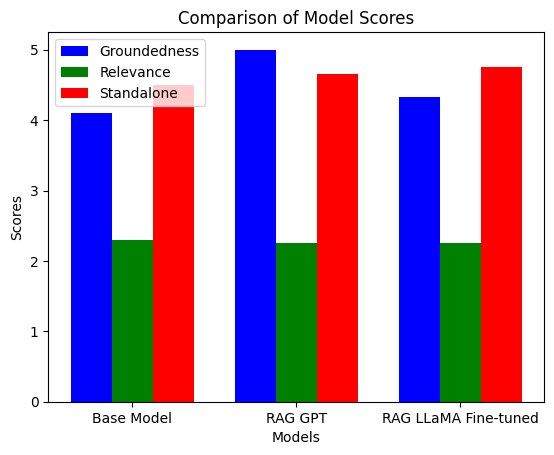

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# Data
models = ['Base Model', 'RAG GPT', 'RAG LLaMA Fine-tuned']
groundedness = [groundedness_score_avg, groundedness_score_rag_gpt_avg, groundedness_score_rag_llama_finetune_avg]
relevance = [relevance_score_avg, relevance_score_rag_gpt_avg, relevance_score_rag_llama_finetune_avg]
standalone = [standalone_score_avg, standalone_score_avg_rag_gpt_avg, standalone_score_rag_llama_finetune_avg]

# Set width of bars
barWidth = 0.25

# Set positions of bar on X axis
r1 = np.arange(len(models))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]

# Create bars
plt.bar(r1, groundedness, color='blue', width=barWidth, label='Groundedness')
plt.bar(r2, relevance, color='green', width=barWidth, label='Relevance')
plt.bar(r3, standalone, color='red', width=barWidth, label='Standalone')

# Add xticks on the middle of the group bars
plt.xlabel('Models')
plt.ylabel('Scores')
plt.title('Comparison of Model Scores')
plt.xticks([r + barWidth for r in range(len(models))], models)

# Create legend
plt.legend()

# Show graphic
plt.show()
